In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
import timeit
%matplotlib inline

In [2]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# options of samples

In [67]:
#store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1203.h5')
#data1 = store['APCdata']

In [68]:
#store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1206.h5')
#data2 = store['APCdata']

In [69]:
#store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1209.h5')
#data3 = store['APCdata']

In [70]:
'''
def day_sample(data, month, start_date, end_date):
    month = data.loc[data['mo'] == month]
    day_sample = month[(month['day'] >= start_date) & (month['day'] <= end_date)]
    return day_sample

'''

"\ndef day_sample(data, month, start_date, end_date):\n    month = data.loc[data['mo'] == month]\n    day_sample = month[(month['day'] >= start_date) & (month['day'] <= end_date)]\n    return day_sample\n\n"

In [71]:
'''
Apr_sample = day_sample(data1, 4, 24, 26)
May_sample = day_sample(data1, 5, 2, 4)
'''

'\nApr_sample = day_sample(data1, 4, 24, 26)\nMay_sample = day_sample(data1, 5, 2, 4)\n'

In [72]:
'''
Sep_sample1 = day_sample(data2, 9, 18, 20)
Sep_sample2 = day_sample(data2, 9, 25, 27) 
Oct_sample1 = day_sample(data3, 10, 2, 4)
Oct_sample2 = day_sample(data3, 10, 9, 11)
Oct_sample3 = day_sample(data3, 10, 16, 18)
Oct_sample4 = day_sample(data3, 10, 23, 25)
'''

'\nSep_sample1 = day_sample(data2, 9, 18, 20)\nSep_sample2 = day_sample(data2, 9, 25, 27) \nOct_sample1 = day_sample(data3, 10, 2, 4)\nOct_sample2 = day_sample(data3, 10, 9, 11)\nOct_sample3 = day_sample(data3, 10, 16, 18)\nOct_sample4 = day_sample(data3, 10, 23, 25)\n'

In [73]:
'''
Spring_Fall_Sample = pd.concat([Apr_sample, May_sample, Sep_sample1, Sep_sample2, Oct_sample1, Oct_sample2, Oct_sample3, Oct_sample4], ignore_index=True)
'''

'\nSpring_Fall_Sample = pd.concat([Apr_sample, May_sample, Sep_sample1, Sep_sample2, Oct_sample1, Oct_sample2, Oct_sample3, Oct_sample4], ignore_index=True)\n'

In [74]:
#Spring_Fall_Sample.to_csv('R:/Angela/fast_trips/SampleDataSpringFall.csv')

In [3]:
#Spring_Fall_Sample.to_csv('R:/Angela/fast_trips/SampleDataSpringFall.csv')
Spring_Fall_Sample = pd.read_csv('R:/Angela/fast_trips/SampleDataSpringFall.csv')

In [4]:
sample1 = Spring_Fall_Sample

In [5]:
Oct = sample1.loc[sample1.mo == 10]

In [6]:
Oct = Oct[(Oct['day'] <= 18)]

In [7]:
sample1 = sample1[(sample1['mo'] <= 9)]

In [9]:
Spring_Fall_Sample2 = pd.concat([Oct, sample1])

In [10]:
Spring_Fall_Sample2.shape

(2090609, 55)

In [11]:
Spring_Fall_Sample2.to_csv('R:/Angela/fast_trips/SampleDataSpringFall2.csv')

In [ ]:
Sample = pd.read_csv('R:/Angela/fast_trips/SampleDataSpringFall2.csv')

#my_data

In [12]:
my_data = Spring_Fall_Sample

In [13]:
#try a small sample if needed
'''
msk = np.random.rand(len(Spring_Fall_Sample)) < 0.95
my_data = Spring_Fall_Sample[~msk]
'''

'\nmsk = np.random.rand(len(Spring_Fall_Sample)) < 0.95\nmy_data = Spring_Fall_Sample[~msk]\n'

In [14]:
my_data.shape

(2090609, 55)

In [15]:
def content_need(data):
    data = data[['on', 'off', 'vehno', 'route', 'stop_name', 'stop_sequence', 'mo', 'yr', 
                 'arr_hour', 'arr_min', 'arr_sec', 'dep_hr', 'dep_min', 'dep_sec', 'load', 'capacity']]
    return data

In [16]:
test = content_need(my_data)

In [17]:
test.shape

(2090609, 16)

#Prepare bus info

In [18]:
vehicles = pd.read_csv(r'R:\Angela\fast_trips\Vehicles.csv')
fleet = pd.read_csv(r'R:\Angela\fast_trips\Copy of Fleet.csv')
vehicles.Artic = vehicles.Length.map({60 : 1, 40 : 0, 30 : 0})
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']

# Prepare route type

In [19]:
route_type = pd.read_csv(r'R:\Angela\fast_trips\MuniRouteTypes.csv')
route_type = route_type.dropna()
dict_route_type = {}
dict_route_type = route_type.set_index('APC Route ID')['Type'].to_dict()

#Step1: Prepare basic variables

In [20]:
def get_x_y(data):
    start = timeit.default_timer()
    # Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['on', 'off', 'vehno'])
    # Input bus type info into raw data
    # COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['EOL']= data.apply(lambda x: '- EOL' in x['stop_name'], axis=1).map({False: 1, True: 0})
    # Remove the last stop
    data = data.loc[data['EOL'] == 1]
    # Remove the first stop
    data = data.loc[data['stop_sequence'] != 1]
    stop = timeit.default_timer()
    print 'clean data:', stop - start

    # COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    start = timeit.default_timer()
    data['COMPUTE_TIMESTOP'] = data['arr_hour']*3600 + data['arr_min']*60 + data['arr_sec']
    # COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data['dep_hr']*3600 + data['dep_min']*60 + data['dep_sec']
    # COMPUTE DOORDWELL=DOORCLOSE - TIMESTOP
    data['COMPUTE_DOORDWELL'] = data['COMPUTE_DOORCOLSE'] - data['COMPUTE_TIMESTOP']
    # Appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 120]
    stop = timeit.default_timer()
    print 'compute dwell time:', stop - start

    # Keep rows that satisfy a query:
    start = timeit.default_timer()
    data['Doors'] = data['vehno'].map(df_vehnum_doors) 
    data['Artic'] = data['vehno'].map(df_vehnum_artic)
    data['Floor'] = data['vehno'].map(df_vehnum_floor)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    data['all_door_boarding']= data.apply(lambda x: x['mo'] > 6, axis=1).map({False: 0, True: 1})
    # Create dummie variables for route id
    data['Route Type'] = data['route'].map(dict_route_type)
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    step_1.drop(['Local'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start

    # Create interaction variables
    start = timeit.default_timer()
    data['on_threedoors'] = data['on']*data['three_doors']
    data['off_threedoors'] = data['off']*data['three_doors']
    data['on_floor'] = data['on']*data['Floor']
    data['off_floor'] = data['off']*data['Floor']
    data['floor_threedoors'] = data['Floor']*data['three_doors']
    data['floor_twodoors'] = data['Floor']*data['two_doors']
    data['on_all_door_boarding'] = data['on']*data['all_door_boarding']
    data['off_all_door_boarding'] = data['off']*data['all_door_boarding']
    data['on_express'] = data['on']*data['Express']
    data['off_express'] = data['off']*data['Express']
    data['on_rapid'] = data['on']*data['Rapid']
    data['off_rapid'] = data['off']*data['Rapid']
    data['on_owl'] = data['on']*data['OWL']
    data['off_owl'] = data['off']*data['OWL']
    stop = timeit.default_timer()
    print 'add interaction variables:', stop - start

    return data

## Step2: Adding more passenger activity variables

In [21]:
def passenger_var(data):
    start = timeit.default_timer()
    data['max_pasg'] = data[['on', 'off']].max(axis=1)
    print 'data shape:', data.shape
    data['abs_pasg'] = (data['on'] - data['off']).abs()
    print 'data shape:', data.shape
    
    # A passenger friction factor was constructed to account for passenger activity on buses with standees. 
    # It was posited that heavily loaded buses have greater dwell times. 
    # STANDEES are the number of passengers when LOAD minus 85% of bus capacity is positive. 
    data['pre_standees']= data['load'] - 0.85 * data['capacity']
    data['pre_crowding']= data.apply(lambda x: x['pre_standees'] > 0, axis=1).map({False: 0, True: 1})
    # A proxy variable was constructed by adding ONS, OFFS, and STANDEES.
    data['friction'] = ((data['on'] + data['off'] + (data['pre_standees']).abs()) * data['pre_crowding']).abs()
    print 'data shape:', data.shape
    stop = timeit.default_timer()
    print 'add passenger activity variables:', stop - start
    
    return data

# Step3: Prepare vehicle ID variables

In [23]:
# Create dummie variables for bus id 
def create_vehID(data):
    start = timeit.default_timer()
    just_dummies_veh = pd.get_dummies(data['vehno'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    #step_1.drop([8515], inplace=True, axis=1)
    stop = timeit.default_timer()
    print 'data shape:', data.shape
    print 'add bus id variables:', stop - start
    
    return data

# Step4: Delete a vehicle variable in each route type

In [24]:
# To check whether vehcle:8515 is in the sample, if it is not, we should pick up another veh id to delete
# For every route type, get rid of one dummy bus id variable, to avoid the dummy variable trap
# step1 = data.drop([owl_veh], inplace=True, axis=1)
def del_vehID(data):
    start = timeit.default_timer()
    express = data.loc[data['Express'] == 1]
    express_veh = np.unique(express['vehno'])[1]
    print 'express:', express_veh
    rapid = data.loc[data['Rapid'] == 1]
    rapid_veh = np.unique(rapid['vehno'])[1]
    print 'rapid:', rapid_veh
    owl = data.loc[data['OWL'] == 1]
    owl_veh = np.unique(owl['vehno'])[1]
    print 'OWL:', owl_veh
    print 'data shape:', data.shape
    data = data.drop([express_veh, rapid_veh, owl_veh], 1)
    print 'data shape:', data.shape
    stop = timeit.default_timer()
    print 'delete vehicle variables:', stop - start
    
    return data

# Prepare model inputs

In [25]:
step1 = get_x_y(test)

clean data: 27.0845939789
compute dwell time: 0.643038057978
add veh&route info: 27.7283178369
add interaction variables: 0.168346403881


In [26]:
step2 = passenger_var(step1)

data shape: (1977117, 45)
data shape: (1977117, 46)
data shape: (1977117, 49)
add passenger activity variables: 29.3301837443


In [27]:
step3 = create_vehID(step2)

data shape: (1977117, 287)
add bus id variables: 16.2334962008


In [28]:
step4 = del_vehID(step3)

express: 2802
rapid: 6200
OWL: 6233
data shape: (1977117, 287)
data shape: (1977117, 284)
delete vehicle variables: 5.0435317012


In [29]:
step4.columns[:50]

Index([                   u'on',                   u'off',
                       u'vehno',                 u'route',
                   u'stop_name',         u'stop_sequence',
                          u'mo',                    u'yr',
                    u'arr_hour',               u'arr_min',
                     u'arr_sec',                u'dep_hr',
                     u'dep_min',               u'dep_sec',
                        u'load',              u'capacity',
                         u'EOL',      u'COMPUTE_TIMESTOP',
           u'COMPUTE_DOORCOLSE',     u'COMPUTE_DOORDWELL',
                       u'Doors',                 u'Artic',
                       u'Floor',             u'two_doors',
                 u'three_doors',     u'all_door_boarding',
                  u'Route Type',               u'Express',
                         u'OWL',                 u'Rapid',
               u'on_threedoors',        u'off_threedoors',
                    u'on_floor',             u'off_floor

In [30]:
step4.shape

(1977117, 284)

In [31]:
#Delete data if needed: dwell_time = 0
'''
step4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]
step4.shape
'''

"\nstep4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]\nstep4.shape\n"

In [32]:
# you may need drop some columns
#data = step4.drop(['Unnamed: 0'], axis = 1)
data = step4
print 'finished data preparation'

finished data preparation


In [33]:
data.dropna()
msk = np.random.rand(len(data)) < 0.7
df_train = data[msk]
df_test = data[~msk]

In [34]:
# Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
#X[np.isnan(X)] = np.median(X[~np.isnan(X)])
X_train = df_train.drop(['COMPUTE_DOORDWELL','vehno','stop_name', 'stop_sequence', 'arr_hour','arr_min',
               'arr_sec','route','mo','yr','dep_hr','dep_min','dep_sec', 'EOL',
               'COMPUTE_TIMESTOP','COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors',
               'two_doors', 'Artic', 'Route Type', 'floor_threedoors', 
               'floor_twodoors', 'pre_standees', 'pre_crowding','capacity', 'load'], axis=1)
X_test = df_test.drop(['COMPUTE_DOORDWELL','vehno','stop_name', 'stop_sequence', 'arr_hour','arr_min',
               'arr_sec','route','mo','yr','dep_hr','dep_min','dep_sec', 'EOL',
               'COMPUTE_TIMESTOP','COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors',
               'two_doors', 'Artic', 'Route Type', 'floor_threedoors', 
               'floor_twodoors', 'pre_standees', 'pre_crowding','capacity', 'load'], axis=1)

y_train = df_train.COMPUTE_DOORDWELL
y_test = df_test.COMPUTE_DOORDWELL

stop = timeit.default_timer()
print 'prepare x,y for regression:', stop - start

prepare x,y for regression: 1.13704651397


In [35]:
print df_train.shape
print df_test.shape

(1383760, 284)
(593357, 284)


In [36]:
print X_train.shape
print y_train.shape

(1383760, 258)
(1383760L,)


# Build multi-linear regression model

# Model - with vehicle ids

In [37]:
X2_train = X_train[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors',
            'on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express',
            'off_express','on_rapid','off_rapid','on_owl','off_owl', 'max_pasg', 'abs_pasg', 'friction']]
y2_train = y_train
X2_test = X_test[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors',
            'on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express',
            'off_express','on_rapid','off_rapid','on_owl','off_owl', 'max_pasg', 'abs_pasg', 'friction']]
y2_test = y_test

In [38]:
print X2_test.shape
print y2_test.shape

(593357, 23)
(593357L,)


In [39]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results1 = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results1['pvalues'] = pd.DataFrame(pvalues)
sklearn_results1['scores'] = pd.DataFrame(scores)

stop = timeit.default_timer()
print 'build model with veh ids:', stop - start

build model with veh ids: 27.9048286421


In [40]:
print sklearn_results1

                  features  estimatedCoefficients  pvalues      scores
0                       on         2032564225.545    0.000 2737629.688
1                      off         2032564224.443    0.000 1814360.228
2                    Floor       -18336145143.248    0.000   24506.888
3              three_doors                  5.841    0.000   21108.032
4        all_door_boarding                 -0.435    0.090     141.241
5                  Express                  1.224    0.000    9019.719
6                      OWL                 -1.020    0.000    1053.336
7                    Rapid                  4.507    0.000   28616.524
8            on_threedoors                 -0.128    0.000 1067944.343
9           off_threedoors                 -0.189    0.000  689164.767
10                on_floor                  0.587    0.000  164399.851
11               off_floor                  0.428    0.000  121289.412
12    on_all_door_boarding                 -0.055    0.000 1856545.360
13   o

In [41]:
sklearn_results1.to_csv('R:/Angela/fast_trips/muni_apc_2012/passenger_var_datasets_withVeh_lessOctday.csv')

# Correlation table

In [42]:
corr_results1 = data[['on', 'off','capacity', 'Floor', 'max_pasg', 'abs_pasg', 8401, 8402, 8403, 8404, 8405, 8405, 8407, 8408, 
                      8409, 8410, 8411, 8412, 8415,8415,8416,8451,8503,8504,8505,8506,8507,8508,8511,8515, 8520]]
corr_results1.corr()

,on,off,capacity,Floor,max_pasg,abs_pasg,8401,8402,8403,8404,...,8451,8503,8504,8505,8506,8507,8508,8511,8515,8520
on,1.000,0.270,0.122,-0.090,0.768,0.639,-0.009,-0.014,-0.010,-0.008,...,-0.018,-0.022,-0.030,-0.028,-0.024,-0.033,-0.024,-0.028,-0.016,-0.018
off,0.270,1.000,0.120,-0.090,0.777,0.654,-0.009,-0.015,-0.011,-0.009,...,-0.019,-0.021,-0.030,-0.027,-0.023,-0.031,-0.023,-0.028,-0.015,-0.017
capacity,0.122,0.120,1.000,-0.223,0.148,0.124,-0.044,-0.043,-0.047,-0.040,...,-0.046,-0.039,-0.047,-0.043,-0.039,-0.047,-0.040,-0.043,-0.027,-0.030
Floor,-0.090,-0.090,-0.223,1.000,-0.111,-0.096,0.197,0.192,0.213,0.179,...,0.208,0.177,0.210,0.195,0.176,0.212,0.181,0.195,0.120,0.135
max_pasg,0.768,0.777,0.148,-0.111,1.000,0.930,-0.011,-0.017,-0.014,-0.011,...,-0.023,-0.026,-0.037,-0.034,-0.029,-0.040,-0.029,-0.035,-0.019,-0.021
abs_pasg,0.639,0.654,0.124,-0.096,0.930,1.000,-0.009,-0.014,-0.012,-0.009,...,-0.020,-0.022,-0.032,-0.029,-0.025,-0.035,-0.024,-0.030,-0.017,-0.018
8401,-0.009,-0.009,-0.044,0.197,-0.011,-0.009,1.000,-0.007,-0.008,-0.007,...,-0.008,-0.007,-0.008,-0.007,-0.007,-0.008,-0.007,-0.007,-0.005,-0.005
8402,-0.014,-0.015,-0.043,0.192,-0.017,-0.014,-0.007,1.000,-0.008,-0.007,...,-0.008,-0.007,-0.008,-0.007,-0.007,-0.008,-0.007,-0.007,-0.004,-0.005
8403,-0.010,-0.011,-0.047,0.213,-0.014,-0.012,-0.008,-0.008,1.000,-0.007,...,-0.009,-0.007,-0.009,-0.008,-0.007,-0.009,-0.007,-0.008,-0.005,-0.006
8404,-0.008,-0.009,-0.040,0.179,-0.011,-0.009,-0.007,-0.007,-0.007,1.000,...,-0.007,-0.006,-0.007,-0.007,-0.006,-0.007,-0.006,-0.007,-0.004,-0.005


In [43]:
np.unique(X_train.all_door_boarding)

array([0, 1], dtype=int64)

# Plots - with vehicle ID

In [44]:
# Pre-check whether there is any negative value in (y_train)
c = 0
for ele in y_train:
    if ele < 0:
        print ele
        c += 1
if c == 0:
    print 'there is no nagative value in y_tain'

there is no nagative value in y_tain


In [45]:
# Pre-check whether there is any negative value in lm.predict(X_train), and how many
neg_dict = {}
j = 0
for ele in range(1, len(X_train)):
    i = ele-1
    #print i
    if lm1.predict(X_train[i:ele])<0: 
        neg_dict[ele] = lm1.predict(X_train[i:ele])
        j += 1
print j

6467


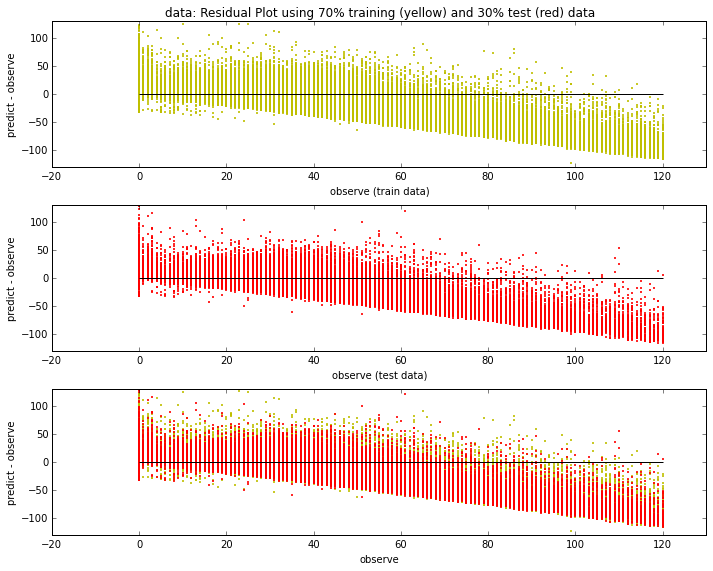

In [47]:
plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.tight_layout()
plt.figure(figsize=(10,5))
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

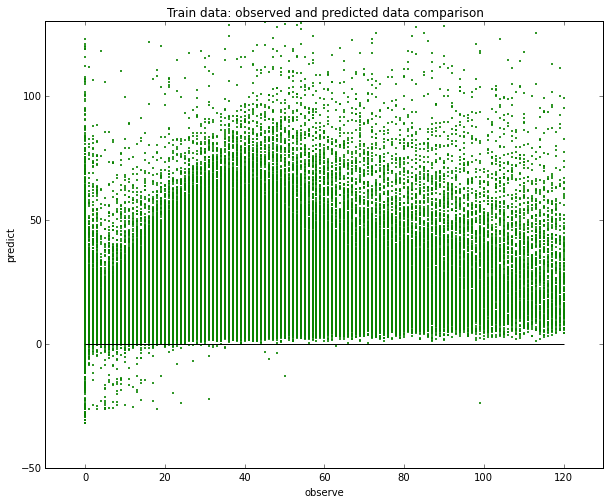

In [48]:
plt.figure(1)

plt.scatter(y_train, lm1.predict(X_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -50, 130])
plt.title('Train data: observed and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

z: 19131.612078
sort data: 0.0485357474754


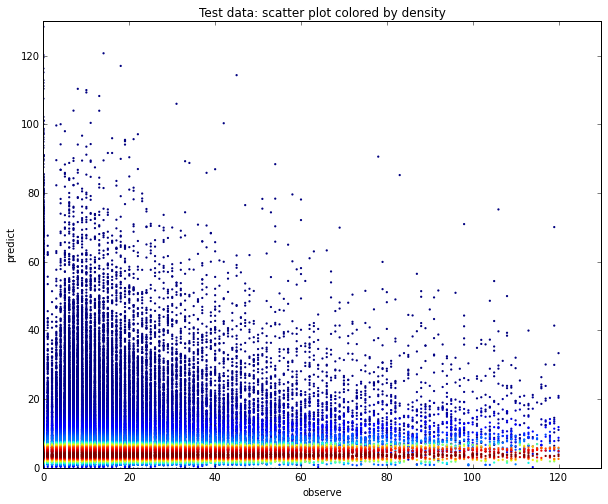

In [49]:
x = y_test
y = lm1.predict(X_test)

# Calculate the point density
start = timeit.default_timer()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
stop = timeit.default_timer()
print 'z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z.argsort()
stop = timeit.default_timer()
print 'sort data:', stop - start

x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, edgecolor='')
plt.axis([0, 130, 0, 130])
plt.title('Test data: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()

# Model - without vehicle IDs

In [50]:
X2_train = X_train[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors',
            'on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express',
            'off_express','on_rapid','off_rapid','on_owl','off_owl', 'max_pasg', 'abs_pasg', 'friction']]
y2_train = y_train
X2_test = X_test[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors',
            'on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express',
            'off_express','on_rapid','off_rapid','on_owl','off_owl', 'max_pasg', 'abs_pasg', 'friction']]
y2_test = y_test
print len(X2_train)
print len(y2_train)
print len(X2_test)
print len(y2_test)

1383760
1383760
593357
593357


In [51]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)
stop = timeit.default_timer()
print 'build model without veh ids:', stop - start

build model without veh ids: 15692.4624985


In [52]:
print sklearn_results2

                 features  estimatedCoefficients  pvalues      scores
0                      on           36018749.027    0.000 2737629.688
1                     off           36018747.918    0.000 1814360.228
2                   Floor                 -2.146    0.000   24506.888
3             three_doors                  1.092    0.000   21108.032
4       all_door_boarding                 -0.418    0.090     141.241
5                 Express                  1.044    0.000    9019.719
6                     OWL                 -1.189    0.000    1053.336
7                   Rapid                  4.611    0.000   28616.524
8           on_threedoors                 -0.126    0.000 1067944.343
9          off_threedoors                 -0.181    0.000  689164.767
10               on_floor                  0.611    0.000  164399.851
11              off_floor                  0.455    0.000  121289.412
12   on_all_door_boarding                 -0.069    0.000 1856545.360
13  off_all_door_boa

In [53]:
sklearn_results2.to_csv('R:/Angela/fast_trips/muni_apc_2012/passenger_var_datasets_withoutVeh_lessOctday.csv')

# Correlation table

In [54]:
corr_results2 = data[['on', 'off','max_pasg', 'abs_pasg']]
corr_results2.corr()

,on,off,max_pasg,abs_pasg
on,1.000,0.270,0.768,0.639
off,0.270,1.000,0.777,0.654
max_pasg,0.768,0.777,1.000,0.930
abs_pasg,0.639,0.654,0.930,1.000


# Plots

In [55]:
# Pre-check whether there is any negative value in lm2.predict(X2_train), and how many
neg_dict = {}
q = 0
for ele in range(1, len(X2_train)):
    i = ele-1
    #print i
    if lm2.predict(X2_train[i:ele])<0: 
        neg_dict[ele] = lm2.predict(X2_train[i:ele])
        q += 1
print q

1118


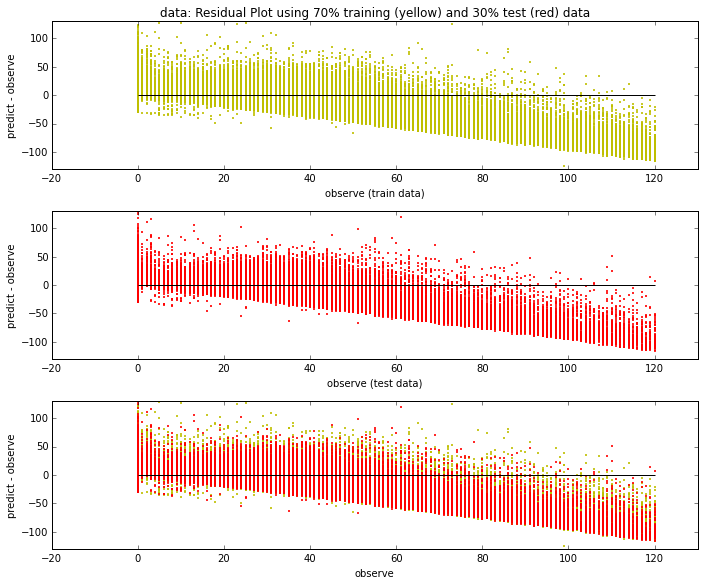

In [56]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')

plt.tight_layout()
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.show()

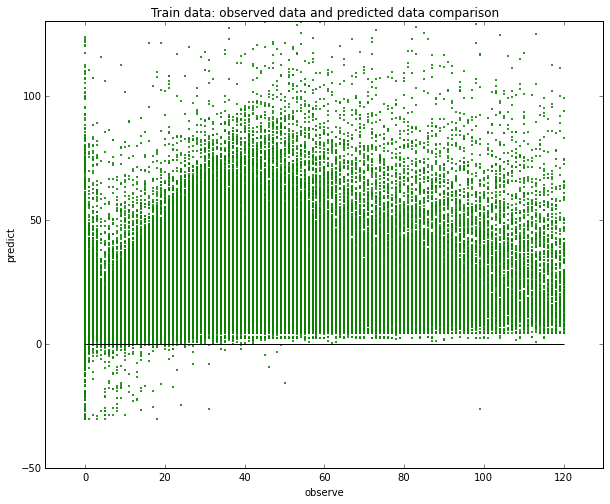

In [57]:
plt.figure(1)

plt.scatter(y2_train, lm2.predict(X2_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -50, 130])
plt.title('Train data: observed data and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()

In [ ]:
x2 = y2_test
y2 = lm2.predict(X2_test)

# Calculate the point density
start = timeit.default_timer()
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)
stop = timeit.default_timer()
print 'z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z2.argsort()
stop = timeit.default_timer()
print 'sort data:', stop - start

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

plt.axis([0, 130, 0, 130])
plt.title('Test dataset: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.show()

In [ ]:
print 'end'